### linear Regression models

### Use advertising data to build a model to predict sales based on advertising through TV, Radio and Newspaper

In [1]:
import pandas                       as     pd
import numpy                        as     np
import scipy.stats                  as     stats

import seaborn                      as     sns
import matplotlib.pyplot            as     plt
import matplotlib

matplotlib.rcParams.update({'font.size': 12})

import astropy.table                as     Table
import statsmodels.api              as     sm
import statsmodels.stats.api        as     sms
from   statsmodels.compat           import lzip


#from   sklearn.preprocessing        import PolynomialFeatures
from   sklearn.cross_validation     import train_test_split
from   sklearn.linear_model         import LinearRegression
from   sklearn.linear_model         import Ridge
from   sklearn.linear_model         import Lasso
from   sklearn.model_selection      import GridSearchCV


from   sklearn.metrics              import mean_squared_error
from   statsmodels.compat           import lzip
from   statsmodels.stats            import diagnostic as diag


from  statsmodels.stats.outliers_influence import variance_inflation_factor


D:\Python\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
carseats_df       = pd.read_csv('D:/RRD/data/Carseats.csv', \
                                usecols = ['CompPrice', 'Income', 'Advertising', 'Population', 'Price',\
                                           'Age', 'Education','Sales'])
print(carseats_df.shape)
print(carseats_df.head().T)

(400, 8)
                 0       1       2      3       4
Sales          9.5   11.22   10.06    7.4    4.15
CompPrice    138.0  111.00  113.00  117.0  141.00
Income        73.0   48.00   35.00  100.0   64.00
Advertising   11.0   16.00   10.00    4.0    3.00
Population   276.0  260.00  269.00  466.0  340.00
Price        120.0   83.00   80.00   97.0  128.00
Age           42.0   65.00   59.00   55.0   38.00
Education     17.0   10.00   12.00   14.0   13.00


### Check for missing values

In [4]:
carseats_df .info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
Age            400 non-null int64
Education      400 non-null int64
dtypes: float64(1), int64(7)
memory usage: 25.1 KB


In [5]:
carseats_df.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
Age            0
Education      0
dtype: int64

In [6]:
__            = carseats_df.apply(lambda x: x.replace(to_replace = 0, value = np.NaN))
carseats_df_  =  pd.DataFrame(__.dropna())

In [7]:
print(type(carseats_df_))

<class 'pandas.core.frame.DataFrame'>


In [8]:
carseats_df_.shape

(256, 8)

## There are no missing values

## Split the data set into dependent and independent variables, X and y

In [9]:
X          =   carseats_df_[['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']]
y          =   carseats_df_['Sales']
print(X.shape)                            
print(y.shape) 

(256, 7)
(256,)


## Build the model using statsmodel using the entire data to check assumptions

In [10]:
X_            = sm.add_constant(X, has_constant= 'skip') # Add an intercept to our model
model         = sm.OLS(y, X_).fit() ## OLS(output, input)
predictions   = model.predict(X_)

## Print the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     35.57
Date:                Wed, 29 May 2019   Prob (F-statistic):           3.57e-34
Time:                        21:11:36   Log-Likelihood:                -538.60
No. Observations:                 256   AIC:                             1093.
Df Residuals:                     248   BIC:                             1122.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.4600      1.547      4.824      0.000       4.414      10.506
CompPrice       0.0897      0.010      8.743      0.000       0.069       0.110
Income          0.0139      0.005      3.024      0.003       0.005       0.023
Advertising     0.1390      0.024      5.816      0.000       0.092       0.186
Population     -0.0005      0.001     -0.572      0.568      -0.002       0.001
Price          -0.0912      0.007    -13.395      0.000      -0.105      -0.078
Age            -0.0491      0.008     -5.979      0.000      -0.065      -0.033
Education       0.0171      0.048      0.354      0.723      -0.078       0.112
==============================================================================
Omnibus:                        6.790   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.105
Skew:                           0.311   Prob(JB):                       0.0472
Kurtosis:                       2.570   Cond. No.                     4.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 1) No outliers

Firstly we try to get the studentized residuals using get_influence( ). 

In [11]:
influence     = model.get_influence()  
resid_student = influence.resid_studentized_external

In [12]:
resid = pd.concat([X_, pd.Series(resid_student,name = "Studentized Residuals")],axis = 1)
resid.head()

,const,CompPrice,Income,Advertising,Population,Price,Age,Education,Studentized Residuals
0,1.0,138.0,73.0,11.0,276.0,120.0,42.0,17.0,-0.006429
1,1.0,111.0,48.0,16.0,260.0,83.0,65.0,10.0,0.830146
2,1.0,113.0,35.0,10.0,269.0,80.0,59.0,12.0,0.363593
3,1.0,117.0,100.0,4.0,466.0,97.0,55.0,14.0,-0.472196
4,1.0,141.0,64.0,3.0,340.0,128.0,38.0,13.0,-1.893941


If the absolute value of studentized residuals is more than 3 then that observation is considered as an outlier and hence should be removed.

In [13]:
print(X_[np.absolute(resid['Studentized Residuals'] > 3)]) 

Empty DataFrame
Columns: [const, CompPrice, Income, Advertising, Population, Price, Age, Education]
Index: []


D:\Python\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


### There are no outliers

### 2) No multi-collinearity

https://www.listendata.com/2018/01/linear-regression-in-python.html

Multi-collinearity increases the estimate of standard error of regression coefficients which makes some variables statistically insignificant when they should be significant.

We can detect multi-collinearity by:
+ By plotting scatter plots between predictor variables to have a visual description of their relationship.
+ By calculating the correlation coefficients between the variables we learn the extent of multi-collinearity in the data.
+ By calculating the Variable Inflation Factor (VIF) for each variable. 
VIF measures how much the variance of an estimated regression coefficients increases if your predictors are correlated.  The higher the value of VIF for the regressor, the more it is highly correlated to other variables.

VIF for a predictor variable is given by $\frac{1}{1 - R^2}$.
Here we take one of the explanatory variables as the target variable and all others as independent variables. So we run a regression between one of those independent variables with remaining independent variables. 

####  Detecting and Removing Multicollinearity 

##### We use the statsmodels library to calculate VIF

In [14]:
def calculate_vif(x):
    thresh = 5.0
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values, j) for j in range(x.shape[1])]
    for i in range(1,k):
        print("Iteration no.")
        print(i)
        print(vif)
        a = np.argmax(vif)
        print("Max VIF is for variable no.:")
        print(a)
        if vif[a] <= thresh :
            break
        if i == 1 :          
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif i > 1 :
            output = output.drop(output.columns[a],axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)


In [15]:
X_pure = calculate_vif(X) 

Iteration no.
1
[63.9654091098325, 6.69122822119715, 4.93426641627, 5.09682808857562, 41.128879805444235, 11.076349822247904, 22.99182106669391]
Max VIF is for variable no.:
0
Iteration no.
2
[6.478826241484748, 4.929166359100747, 5.054862402619069, 17.392128188809856, 10.250095080806052, 20.510708124062244]
Max VIF is for variable no.:
5
Iteration no.
3
[6.345088171250674, 4.816738460132506, 5.05301790070827, 11.010622421977132, 8.615701106010986]
Max VIF is for variable no.:
3
Iteration no.
4
[5.6508155528195205, 4.630467807111045, 4.743183330815087, 6.342832468311356]
Max VIF is for variable no.:
3
Iteration no.
5
[4.077115860865225, 4.255987140390556, 4.416626008438578]
Max VIF is for variable no.:
2


In [16]:
X_pure.shape 

(256, 3)

In [17]:
X_pure.head()

,Income,Advertising,Population
0,73,11.0,276
1,48,16.0,260
2,35,10.0,269
3,100,4.0,466
4,64,3.0,340


#### There is no multi-collinearity as their value is below 5

### 3) Constant variance

Checking heteroscedasticity Using Goldfeld Quandt we test for heteroscedasticity.
Null Hypothesis: Error terms are homoscedastic
Alternative Hypothesis: Error terms are heteroscedastic.

In [18]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model.resid, model.model.exog)
lzip(name, test)

[('F statistic', 1.0962754425156136), ('p-value', 0.30772043495431517)]

The p-value is 0.0708 hence we can say that the residuals have constant variance. 

### 4) No autocorrelation

#### Checking for autocorrelation To ensure the absence of autocorrelation we use Ljungbox test.

####  Null Hypothesis: Autocorrelation is absent.
#### Alternative Hypothesis: Autocorrelation is present.

In [19]:
diag.acorr_ljungbox(model.resid, lags = 1) 

(array([0.04976455]), array([0.82347348]))

Since p-value is 0.5042 thus we can accept the null hypothesis and can say that autocorrelation is absent.

### 5) Normality of the residuals

#### We use Jarque-Bera test  from scipy library to check the normality of residuals.

#### Null Hypothesis: The residuals are normally distributed.

####  Alternative Hypothesis: The residuals are not normally distributed.

In [20]:
jb_stat, jb_pval = stats.jarque_bera(model.resid)
print('Jarque-Bera test P value is %1.4f' % jb_pval)

Jarque-Bera test P value is 0.0472


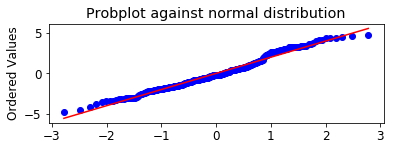

In [21]:
fig     = plt.figure()
ax1     = fig.add_subplot(211)
prob    = stats.probplot(model.resid, dist = stats.norm, plot = ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
plt.show()

D:\Python\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


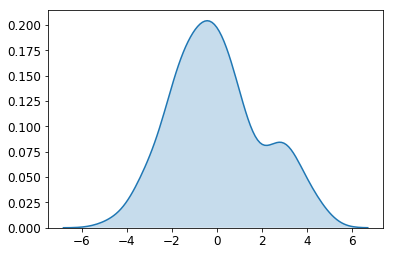

In [22]:
sns.kdeplot(model.resid, shade=True);
plt.show()

## The residuals are not normally distributed since the p-value is < 0.05

By applying various transformations to the variables, we can remove heteroscedasticity of a variable and also make it look like more normally distributed, which is a big deal for statisticians regarding normality and homoscedasticity assumptions for linear models.

https://dataunderthehood.com/2018/01/15/box-cox-transformation-with-python/

In [23]:
from astropy.table import Table
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

D:\Python\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


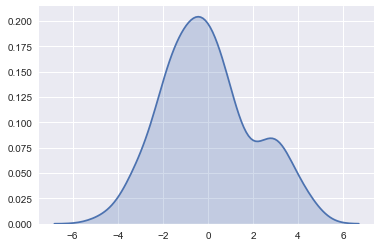

In [24]:
np.random.seed(1144) 
#x = stats.loggamma.rvs(5, size=500) + 5
x  = model.resid
sns.kdeplot(x, shade=True);
 
def normtesttab(x):
    nm_value, nm_p = stats.normaltest(x)
    jb_value, jb_p = stats.jarque_bera(x)
    data_rows = [('D’Agostino-Pearson', nm_value, nm_p),
                 ('Jarque-Bera', jb_value, jb_p)]
    t = Table(rows=data_rows, names=('Test name', 'Statistic', 'p-value'), 
              meta={'name': 'normal test table'},
          dtype=('S25', 'f8', 'f8'))
    print(t)

In [25]:
normtesttab(x)

    Test name          Statistic            p-value      
------------------ ------------------ -------------------
D’Agostino-Pearson  6.790489617716455 0.03353234415236122
       Jarque-Bera 6.1050572143773225  0.0472393235499774



 Various tranformations applied to the variables to make it normal 

....................................................................
Transformation  1 Square root  Jarque-Bera P Value =  0.361707717563883 

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     701.9
Date:                Wed, 29 May 2019   Prob (F-statistic):          2.69e-122
Time:                        21:11:37   Log-Likelihood:                -621.09
No. Observations:                 256   AIC:                             1248.
Df Residuals:                     253   BIC:                             1259.
Df Model:                           3                                         
Covariance Type:            nonrobust                                       

D:\Python\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


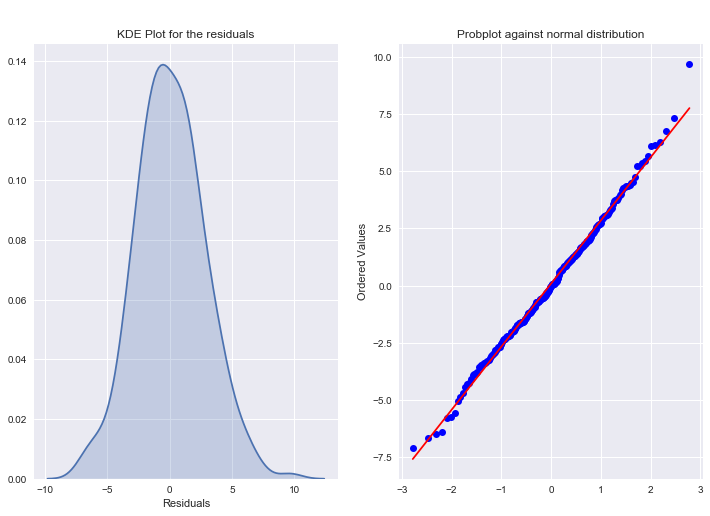

In [26]:
f_cuberoot          = lambda x: np.sign(x) * np.power(abs(x), 1./ 3)
f_squareroot        = lambda x: np.sign(x) * np.power(abs(x), 1./ 2)

xt_vector           = [f_squareroot(X_pure), f_cuberoot(X_pure)]

transformation_list = ['Square root', 'Cube root']

print("\n Various tranformations applied to the variables to make it normal \n")
print('....................................................................')

ind                 = 0
for xt in xt_vector:

    X_c                = xt
    model_c            = sm.OLS(y, X_c).fit()
    jb_value, jb_p     = stats.jarque_bera(model_c.resid)
    transformation     = transformation_list[ind]
    print('Transformation ', ind + 1, transformation, ' Jarque-Bera P Value = ',jb_p, "\n")
    ind               += 1
    if jb_p > 0.05:
        print(model_c.summary())
        normtesttab(model_c.resid)
        fig     = plt.figure(figsize = (12, 8))
        ax1     = fig.add_subplot(121)
        sns.kdeplot(model_c.resid, shade=True, ax = ax1);
        ax1.set_xlabel('Residuals')
        ax1.set_title('KDE Plot for the residuals')
        ax2     = fig.add_subplot(122)
        prob    = stats.probplot(model_c.resid, dist = stats.norm, plot = ax2)
        ax2.set_xlabel('')
        ax2.set_title('\n\nProbplot against normal distribution')
        plt.show()
        Xt      = xt # return the transformed variables
        break

https://www.listendata.com/2018/01/linear-regression-in-python.html

### 6) Linearity

The residual vs fitted values plot is used to check for constant variance and linearity, and to identify potential outliers in the data.

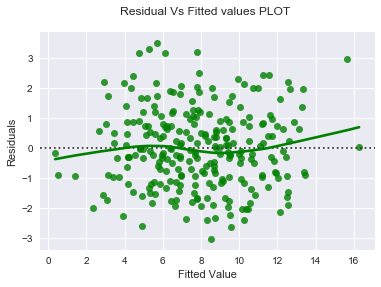

In [27]:
residuals  =  model_c.resid
# Plot the residuals after fitting a linear model
ax         = sns.residplot(y, residuals, lowess = True, color = "g")

ax.set(xlabel='Fitted Value', ylabel='Residuals', title = 'Residual Vs Fitted values PLOT \n')
plt.show()

The residual plot indicates that the model’s residuals are restricting to mean of zero to a great extent exhibiting linearity.

### Split the data into train and test datasets

* Use the train data to build a model.
* Use the test data to evaluate the model performance.
* Slit the data into 80:20 ratio to create train and test data
* Set a random seed to ensure repeatability of the results

In [28]:
x_train, x_test,  y_train, y_test = train_test_split(X_c, y, test_size = 0.30, random_state = 123)

In [29]:
x_train.var()

Income          3.037530
Advertising     0.816116
Population     23.350843
dtype: float64

In [30]:
df_names      = ['x_train shape', 'x_test shape', 'y_train shape', 'y_test shape']
shapes        = (x_train.shape, x_test.shape,  y_train.shape, y_test.shape)
types         = (type(x_train), type(x_test), type(y_train),type(y_test))
lzip(df_names,shapes, types)

[('x_train shape', (179, 3), pandas.core.frame.DataFrame),
 ('x_test shape', (77, 3), pandas.core.frame.DataFrame),
 ('y_train shape', (179,), pandas.core.series.Series),
 ('y_test shape', (77,), pandas.core.series.Series)]

In [31]:
lm                  = sm.OLS(y_train, x_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     449.4
Date:                Wed, 29 May 2019   Prob (F-statistic):           3.16e-82
Time:                        21:11:38   Log-Likelihood:                -438.83
No. Observations:                 179   AIC:                             883.7
Df Residuals:                     176   BIC:                             893.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Income          0.5421      0.088      6.160      

The regression equation is given by:

Sales = 3.86577 + 0.09269 * TV + 0.03462 * Radio + 0.01597 * Newspaper -0.000466 * $TV^2$ + 0.0015105 * TV X Radio - 0.0002586 * TV X Newspaper - 9.39196 * $Radio^2$ - 0.0007483 X Radio X Newspaper + 0.0002933 * $Newspaper^2$  + 0.000000081533 * $TV^3$ - 0.0000016885 * $TV^2$ X Radio - 0.00000100052 * $TV^2$ X Newspaper - 0.0000023998 * $Radio^2$ X TV - 0.00000198309 * $TV$ * $Radio$ * $Newspaper$ - 0.000000332817 * $Newspaper^2$ * TV - 0.00000907886 * $Radio^3$ + 0.0000097386 * $Radio^2$ * Newspaper + 0.0000052069 * $Newspaper^2$ X Radio - 0.000003027 * $Newspaper^3$ 

### Model evaluation

We will evaluate our model using RMSE, MAPE and R2-score.

### Prediction Accuracy

Prediction error or residuals is the difference between the predicted target variable values and the actual target variable vaues.

Most popular measure to evaluate the model performance is Root Mean Square Error (RMSE) which is the arithmatic mean of the sum of the residuals.

The model with low RMSE is the best model among many other models.

In [32]:
# model evaluation for training set

y_train_predict       = lm.predict(x_train)

rmse_train            = np.sqrt(mean_squared_error(y_train, y_train_predict))
mape_train            = mean_absolute_percentage_error(y_train, y_train_predict)

print("The model performance for training set")

print("--------------------------------------")

print('RMSE is {}'.format(rmse_train))

print('MAPE is {}'.format(mape_train))
print('R square is %1.3f' % lm.rsquared_adj)



The model performance for training set
--------------------------------------
RMSE is 2.808462518629578
MAPE is 51.09170713293759
R square is 0.883


In [33]:
print("\n")

print("The model performance for testing set")

print("--------------------------------------")

# model evaluation for testing set
#X_test_                  =   sm.add_constant(x_test) 
y_test_predict           =   lm.predict(x_test)
rmse_test                =   (np.sqrt(mean_squared_error(y_test, y_test_predict)))
mape_test                =   mean_absolute_percentage_error(y_test, y_test_predict)

print('RMSE is {}'.format(rmse_test))
print('MAPE is {}'.format(mape_test))



The model performance for testing set
--------------------------------------
RMSE is 2.5824584762337195
MAPE is 29.878491818809266


Let us see if ridge or lasso regression is better.

### Ridge Regression

For ridge regression, we introduce GridSearchCV, which allow us to automatically perform 5-fold cross-validation with a range of different regularization parameters in order to find the optimal value of alpha.
Ref: https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8

In [34]:
ridge    =  Ridge()

In [35]:
param_dict      =  {'alpha' : [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 20]}
ridge_regressor =  GridSearchCV(ridge, param_dict, scoring = 'neg_mean_squared_error', cv = 5)
ridge_regressor.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [36]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 20}
-7.949037627712441


In [37]:
clf = Ridge(alpha = 20, normalize = True, random_state = 12345)
clf.fit(x_train, y_train)

Ridge(alpha=20, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=12345, solver='auto', tol=0.001)

## Get the coefficients of the Ridge model

In [38]:
coef_dict_ridge = {}
for coef, feat in zip(clf.coef_, x_train.columns):
    coef_dict_ridge[feat] = coef
print(coef_dict_ridge)

{'Income': 0.016204512650195766, 'Advertising': 0.03459332673560616, 'Population': -0.0007058090656801152}


In [39]:
rmse_train_rr    = (np.sqrt(mean_squared_error(y_true = y_train, y_pred = clf.predict(x_train))))
mape_train_rr    = mean_absolute_percentage_error(y_train,y_pred = clf.predict(x_train))

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('RMSE    is {}'.format(rmse_train_rr))
print('MAPE    is {}'.format(mape_train_rr))
print('Rsquare is {}'.format(clf.score(x_train, y_train)))



The model performance for training set
--------------------------------------
RMSE    is 2.8683021694304154
MAPE    is 54.559590265672
Rsquare is 0.008787694760483133


In [40]:
rmse_test_rr    = (np.sqrt(mean_squared_error(y_true = y_test, y_pred = clf.predict(x_test))))
mape_test_rr    = mean_absolute_percentage_error(y_test, y_pred = clf.predict(x_test))

print("\n")
print("The model performance for testing set")
print("--------------------------------------")

print('RMSE is {}'.format(rmse_test_rr ))
print('MAPE is {}'.format(mape_test_rr ))



The model performance for testing set
--------------------------------------
RMSE is 2.6282427328775233
MAPE is 32.95141006941619


In [41]:
lasso                      =  Lasso()

In [42]:
param_dict       =  {'alpha' : [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 20]}
lasso_regressor  =  GridSearchCV(lasso, param_dict, scoring = 'neg_mean_squared_error', cv = 5)
lasso_regressor.fit(x_train, y_train)

D:\Python\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [43]:
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.01}
-7.980100669095018


In [44]:
clf1 = Ridge(alpha = 0.01)
clf1.fit(x_train, y_train)
print('Rsquare is {}'.format(clf1.score(x_train, y_train)))

Rsquare is 0.09011063923786067


### Get the coefficients of the Lasso model

In [45]:
coef_dict_lasso = {}
for coef, feat in zip(clf1.coef_, x_train.columns):
    coef_dict_lasso[feat] = coef
print(coef_dict_lasso)

{'Income': 0.3096822854920943, 'Advertising': 0.7041488780699523, 'Population': -0.03644138258103426}


In [46]:
rmse_train_lasso    = (np.sqrt(mean_squared_error(y_true = y_train, y_pred = clf1.predict(x_train))))
mape_train_lasso    = mean_absolute_percentage_error(y_train,y_pred = clf1.predict(x_train))

print("\n")
print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse_train_lasso ))
print('MAPE is {}'.format(mape_train_lasso ))



The model performance for training set
--------------------------------------
RMSE is 2.748121009940894
MAPE is 52.180390649931205


In [47]:
rmse_test_lasso    = (np.sqrt(mean_squared_error(y_true = y_test, y_pred = clf1.predict(x_test))))
mape_test_lasso    = mean_absolute_percentage_error(y_test, y_pred = clf1.predict(x_test))

print("\n")
print("The model performance for testing set")
print("--------------------------------------")

print('RMSE is {}'.format(rmse_test_lasso ))
print('MAPE is {}'.format(mape_test_lasso ))



The model performance for testing set
--------------------------------------
RMSE is 2.519534372567729
MAPE is 30.774112008935457


http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html